# Connecting to Redshift and customising data

In [1]:
import pandas as pd
import boto3
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
import os

In [ ]:
load_dotenv("keys.env")

# Importing AWS credentials from the environment file
# Replace with your credentials
aws_access_key = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
aws_region = os.getenv("AWS_REGION")

session = boto3.Session(
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    region_name=aws_region
)

redshift_data = session.client('redshift-data')


In [66]:
def run_redshift_query(sql_query, database='dev', workgroup='default-workgroup'):
    
    response = redshift_data.execute_statement(
        WorkgroupName=workgroup,
        Database=database,
        Sql=sql_query
    )
    query_id = response['Id']

    
    while True:
        status = redshift_data.describe_statement(Id=query_id)
        if status['Status'] == 'FINISHED':
            break
        elif status['Status'] == 'FAILED':
            raise Exception(f"Query failed: {status['Error']}")
        time.sleep(1)

   
    result = redshift_data.get_statement_result(Id=query_id)

    
    columns = [col['name'] for col in result['ColumnMetadata']]
    rows = result['Records']
    data = []
    for row in rows:
        data.append([list(cell.values())[0] if cell else None for cell in row])


    df = pd.DataFrame(data, columns=columns)
    return df


In [67]:
# Running redshift query for order related data
order_df = run_redshift_query(
    "SELECT " \
    "od.order_id, " \
    "od.customer_id,"
    "of.num_items_per_order, " \
    "of.total_price_per_order, " \
    #"of.freight_ratio, " \
    #"of.unique_products_per_order," \
    "of.avg_price_per_item, " \
    "of.order_duration_days, " \
    "of.delayed_delivery_days," \
    "od.order_delivered_customer_date, " \
    #"od.order_status, " \
    "od.order_purchase_timestamp," \
    #"oi.price, " \
    "oi.freight_value " \

    "FROM order_level_features of " \
    "JOIN orders_data od ON of.order_id = od.order_id " \
    "JOIN order_items_data oi ON of.order_id = oi.order_id "
)

# Adding freight value to total price to get the final price
order_df['final_price_per_order'] = order_df['total_price_per_order'] + order_df['freight_value']
order_df

,order_id,customer_id,num_items_per_order,total_price_per_order,avg_price_per_item,order_duration_days,delayed_delivery_days,order_delivered_customer_date,order_purchase_timestamp,freight_value,final_price_per_order
0,ae8a60e4b03c5a4ba9ca0672c164b181,e6f959bf384d1d53b6d68826699bba12,1,128.9,128.9,31,-28,2016-11-03 14:04:50,2016-10-03 22:44:10,25.670000,154.570000
1,2f9d791088532b218b41f892cc16073b,937bb74713a47912471275b234236764,1,9.9,9.9,12,-27,2017-01-17 16:57:46,2017-01-05 13:48:48,8.720000,18.620000
2,3bd5b53dee9d54938f56208bcc03d855,644182a0f196539f214b3f8877fb19bd,1,45.9,45.9,8,-51,2017-01-25 13:47:42,2017-01-17 12:15:42,20.799999,66.699999
3,6ff09113fd48861d786d40583b7f2aa3,9b29afbe5be6f07ceca7ecd44ae83a4f,1,659.0,659.0,18,-35,2017-02-06 09:15:59,2017-01-19 20:12:02,30.870001,689.870001
4,72c6b41818d5e645f455986b59b7a964,3917cd13f3dd7d8b6124ce56f00e88ae,1,115.9,115.9,31,-3,2017-02-20 13:34:53,2017-01-20 10:58:23,19.090000,134.990000
...,...,...,...,...,...,...,...,...,...,...,...
72813,311eb3425fa63439e2f9bba0d60d8768,8d0c69a20b7069397a53a0c2f6ea4c0c,1,34.0,34.0,2,-5,2018-08-17 21:17:35,2018-08-15 10:17:16,9.550000,43.550000
72814,991b6f0cb448175a229309dd55699710,cb2db09134b625c16f34f9240653c8b6,1,45.0,45.0,6,-20,2018-08-21 17:28:38,2018-08-15 10:26:57,18.420000,63.420000
72815,fe166f25e5b4e549094b37531b20cd19,d4f95045b6d8e14b9854ca5b2495928b,1,119.0,119.0,6,-1,2018-08-21 17:21:42,2018-08-15 17:00:09,8.090000,127.090000
72816,14666138d6ac727f90a5f2775b282d07,a1b848486ab5bf5941a00cb77f624e97,1,129.0,129.0,11,-18,2018-08-27 20:27:35,2018-08-16 00:42:39,22.830000,151.830000


# Univariate Analysis for exploring feature trends

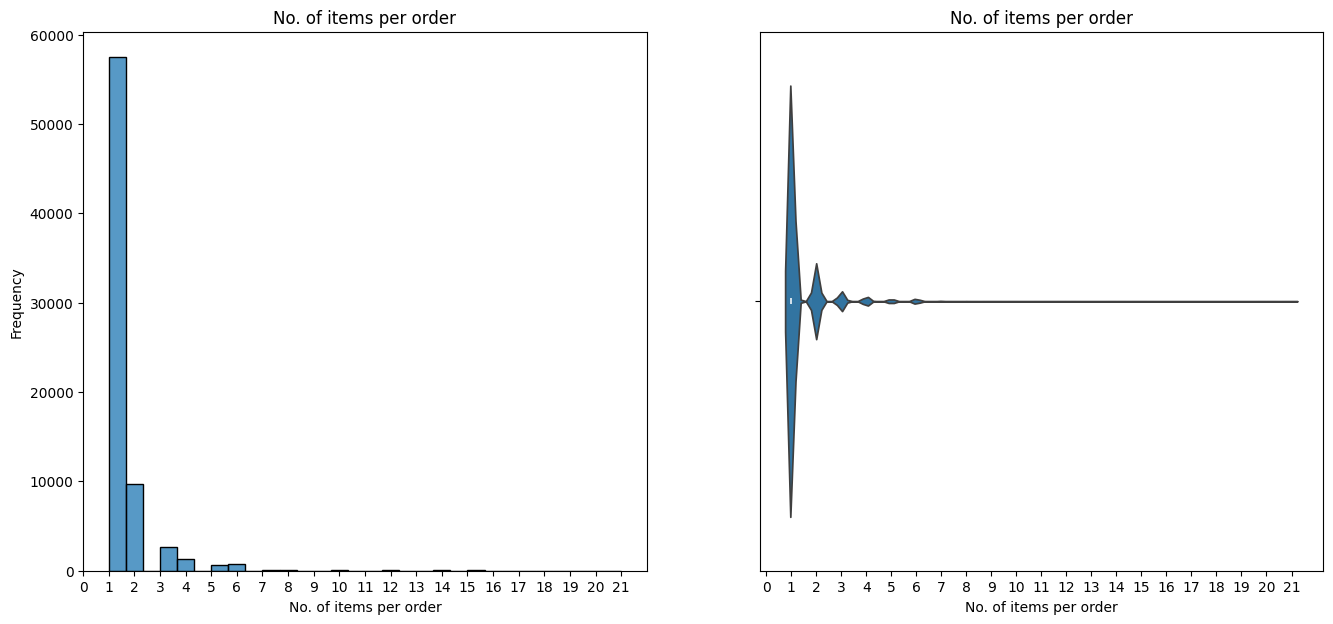

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.histplot(data=order_df, x='num_items_per_order', bins=30, ax=axes[0])
axes[0].set_title('No. of items per order')
axes[0].set_xlabel('No. of items per order')
axes[0].set_ylabel('Frequency')
max_val = order_df['num_items_per_order'].max()
axes[0].set_xticks(np.arange(0, max_val + 1, 1))

sns.violinplot(x='num_items_per_order', data=order_df, inner='box', ax=axes[1])
axes[1].set_title('No. of items per order')
axes[1].set_xlabel('No. of items per order')
max_val = order_df['num_items_per_order'].max()
axes[1].set_xticks(np.arange(0, max_val + 1, 1))

plt.show()

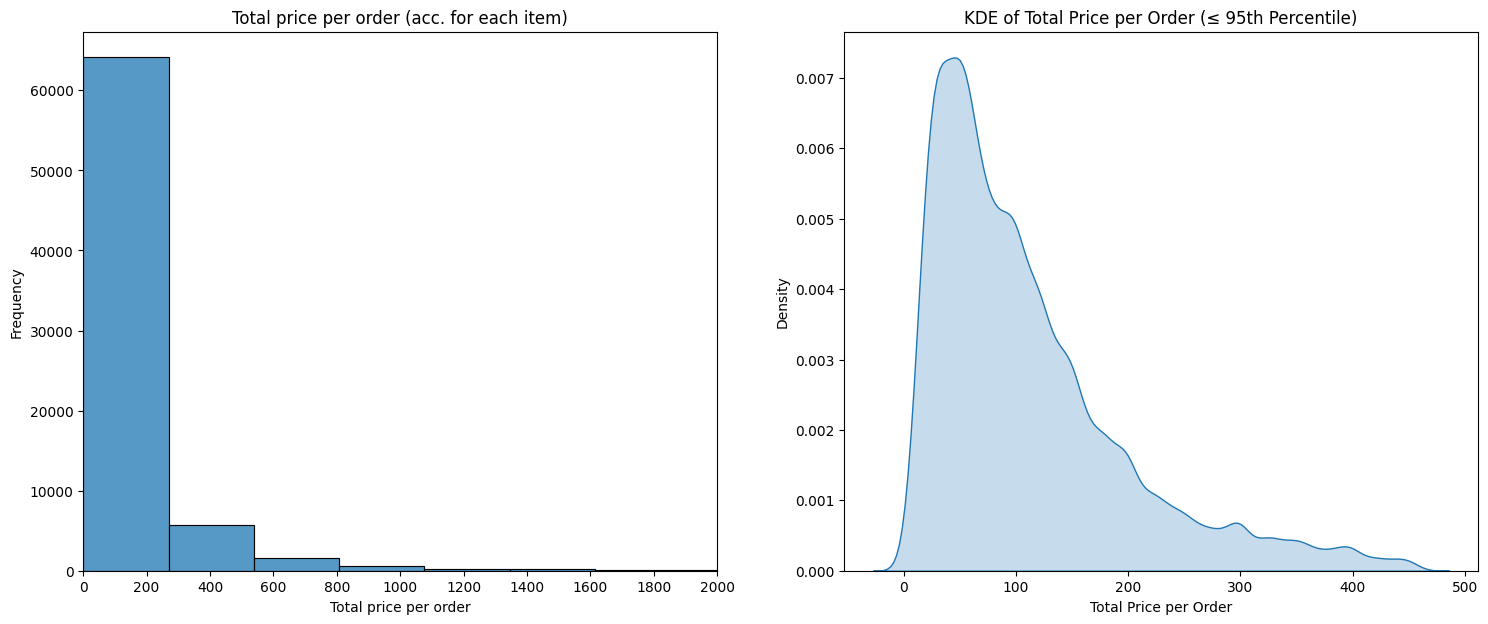

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(data=order_df, x='total_price_per_order', bins=50, ax=axes[0])
axes[0].set_title('Total price per order (acc. for each item)')
axes[0].set_xlabel('Total price per order')
axes[0].set_ylabel('Frequency')
max_val = order_df['total_price_per_order'].max()
axes[0].set_xticks(np.arange(0, max_val + 1, 200))
axes[0].set_xlim(0, 2000) 

price_cutoff = order_df['total_price_per_order'].quantile(0.95)

sns.kdeplot(order_df[order_df['total_price_per_order'] <= price_cutoff]['total_price_per_order'], fill=True, ax=axes[1])
axes[1].set_title('KDE of Total Price per Order (≤ 95th Percentile)')
axes[1].set_xlabel('Total Price per Order')
axes[1].set_ylabel('Density')

plt.show()


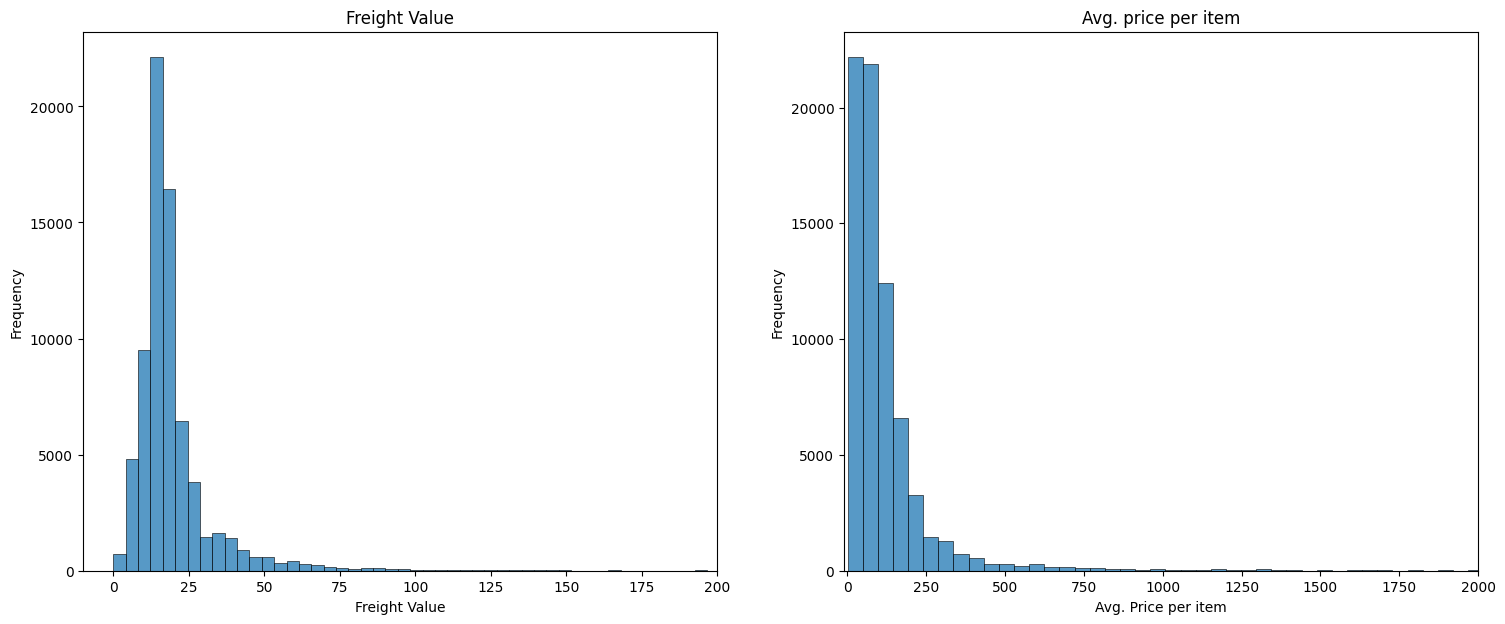

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(data=order_df, x='freight_value', bins=100, ax=axes[0])
axes[0].set_title('Freight Value')
axes[0].set_xlabel('Freight Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim([-10, 200])

sns.histplot(data=order_df, x='avg_price_per_item', bins=100, ax=axes[1])
axes[1].set_title('Avg. price per item')
axes[1].set_xlabel('Avg. Price per item')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim([-10, 2000])

plt.show()

# Stats for Freight Value and Avg. Price per Item to be used as default values in the app
std = order_df['freight_value'].std()
mean = order_df['freight_value'].mean()
median = order_df['freight_value'].median()

std2 = order_df['avg_price_per_item'].std()
mean2 = order_df['avg_price_per_item'].mean()
median2 = order_df['avg_price_per_item'].median()

print(f'std freight_value: {std}')
print(f'mean freight_value: {mean}')
print(f'median freight_value: {median}')

print(f'std avg_p: {std2}')
print(f'mean avg_p: {mean2}')
print(f'median avg_p: {median2}')

# Bivariate Analysis for exploring feature relation trends

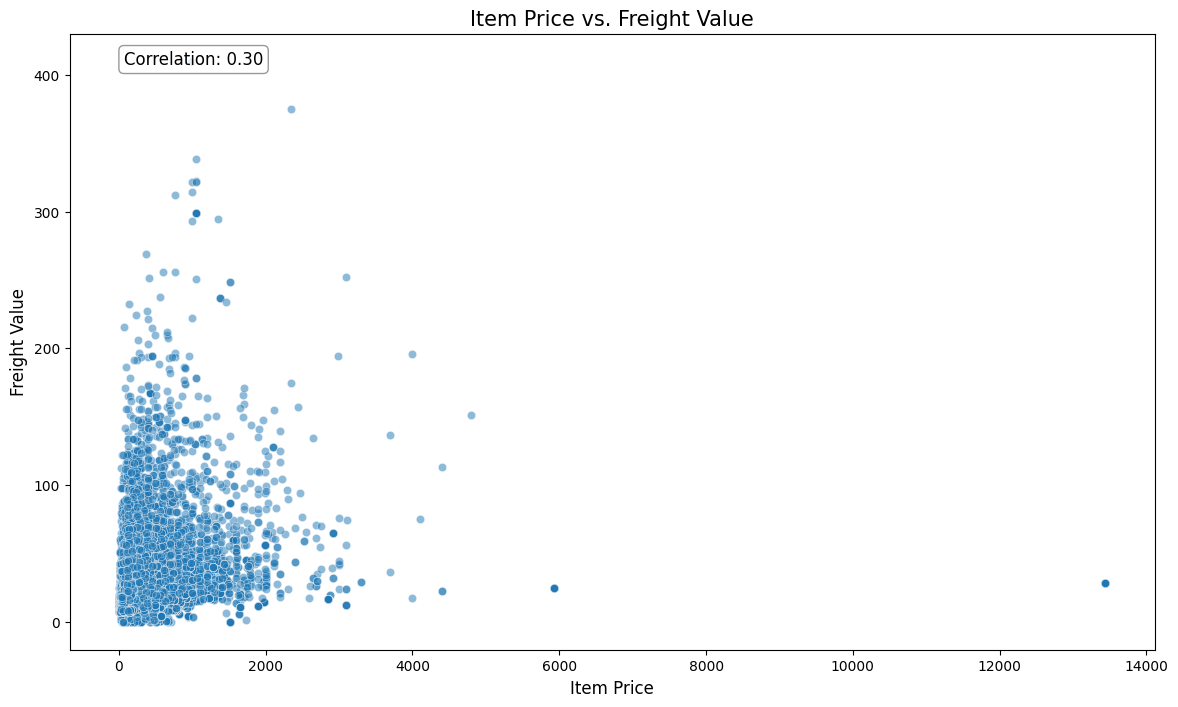

In [70]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='total_price_per_order', y='freight_value', data=order_df, alpha=0.5)
plt.title('Item Price vs. Freight Value', fontsize=15)
plt.xlabel('Item Price', fontsize=12)
plt.ylabel('Freight Value', fontsize=12)

corr = order_df['total_price_per_order'].corr(order_df['freight_value'])
plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.show()

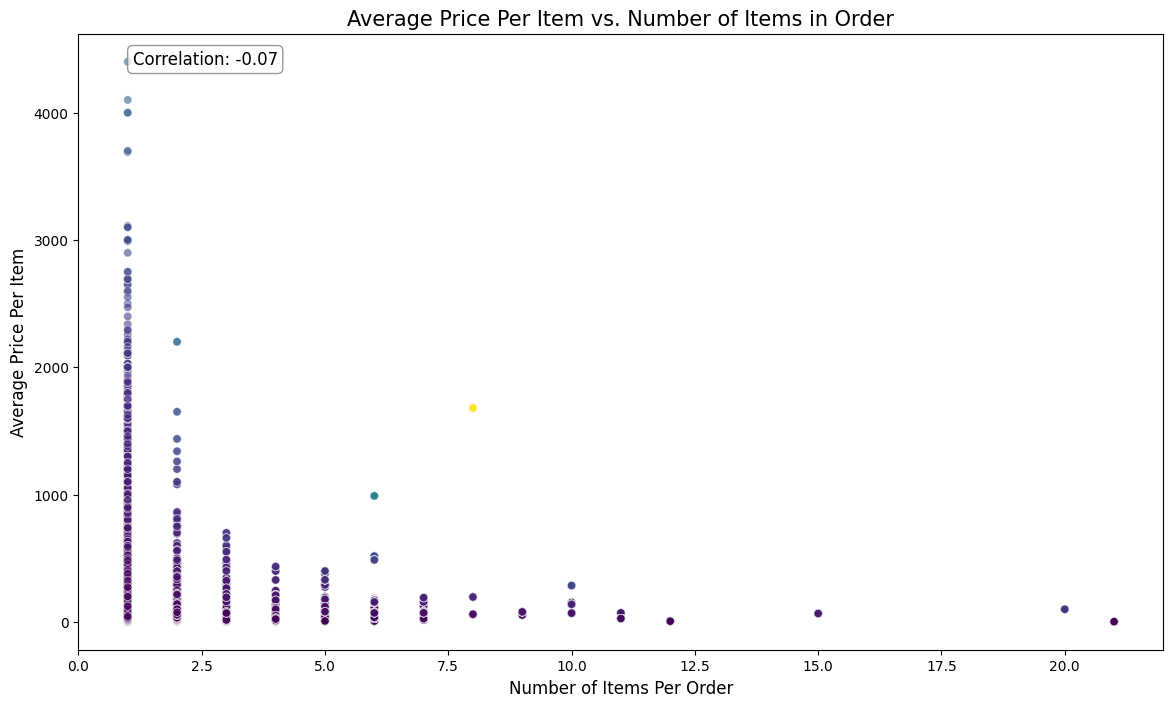

In [ ]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='num_items_per_order', y='avg_price_per_item', 
    data=order_df, alpha=0.6, hue='total_price_per_order', palette='viridis',
    legend=False)

plt.title('Average Price Per Item vs. Number of Items in Order', fontsize=15)
plt.xlabel('Number of Items Per Order', fontsize=12)
plt.ylabel('Average Price Per Item', fontsize=12)

corr = order_df['num_items_per_order'].corr(order_df['avg_price_per_item'])
plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# q_x = order_df['num_items_per_order'].quantile(0.99)
# q_y = order_df['avg_price_per_item'].quantile(0.99)
# plt.xlim(0, q_x)
# plt.ylim(0, q_y)

plt.show()

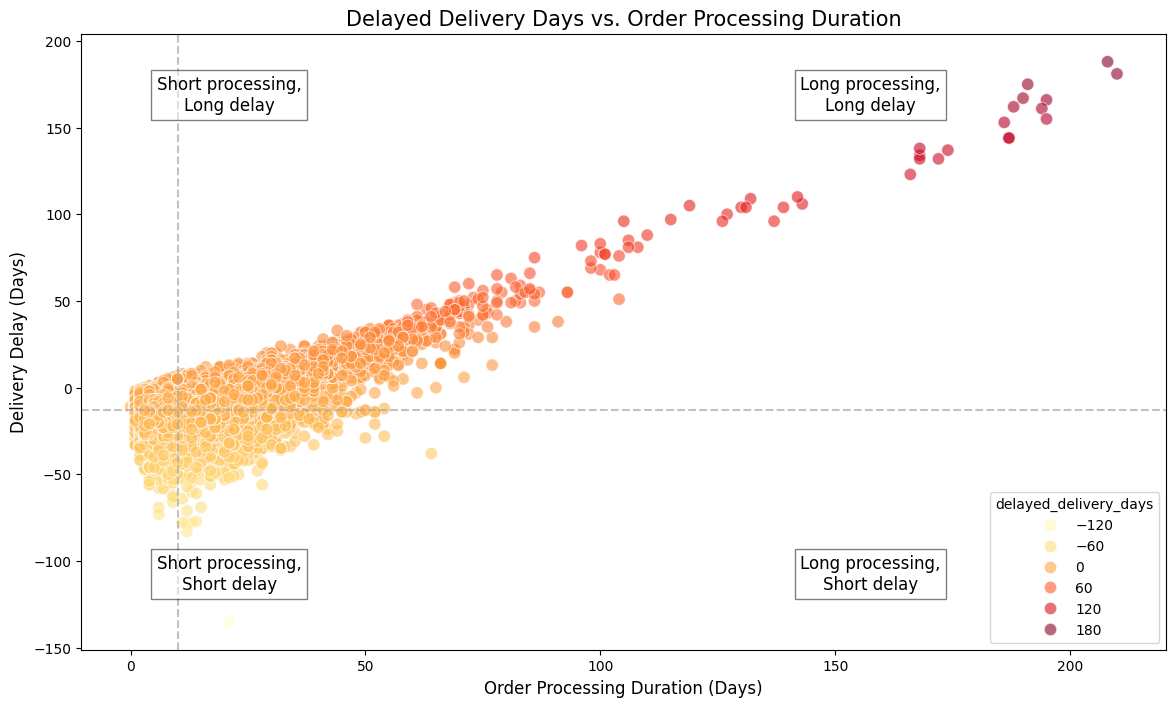

In [ ]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='order_duration_days', y='delayed_delivery_days',
    data=order_df, alpha=0.6, hue='delayed_delivery_days', palette='YlOrRd',
    edgecolor='w',s=80)

median_duration = order_df['order_duration_days'].median()
median_delay = order_df['delayed_delivery_days'].median()

plt.axvline(x=median_duration, color='darkgray', linestyle='--', alpha=0.7)
plt.axhline(y=median_delay, color='darkgray', linestyle='--', alpha=0.7)

plt.text(
    order_df['order_duration_days'].max() * 0.75, 
    order_df['delayed_delivery_days'].max() * 0.85,
    "Long processing,\nLong delay",
    fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5)
)
plt.text(
    order_df['order_duration_days'].min() + (order_df['order_duration_days'].max() * 0.1), 
    order_df['delayed_delivery_days'].max() * 0.85,
    "Short processing,\nLong delay",
    fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5)
)
plt.text(
    order_df['order_duration_days'].max() * 0.75, 
    order_df['delayed_delivery_days'].min() + (order_df['delayed_delivery_days'].max() * 0.1),
    "Long processing,\nShort delay",
    fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5)
)
plt.text(
    order_df['order_duration_days'].min() + (order_df['order_duration_days'].max() * 0.1), 
    order_df['delayed_delivery_days'].min() + (order_df['delayed_delivery_days'].max() * 0.1),
    "Short processing,\nShort delay",
    fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5)
)

plt.title('Delayed Delivery Days vs. Order Processing Duration', fontsize=15)
plt.xlabel('Order Processing Duration (Days)', fontsize=12)
plt.ylabel('Delivery Delay (Days)', fontsize=12)

plt.show()

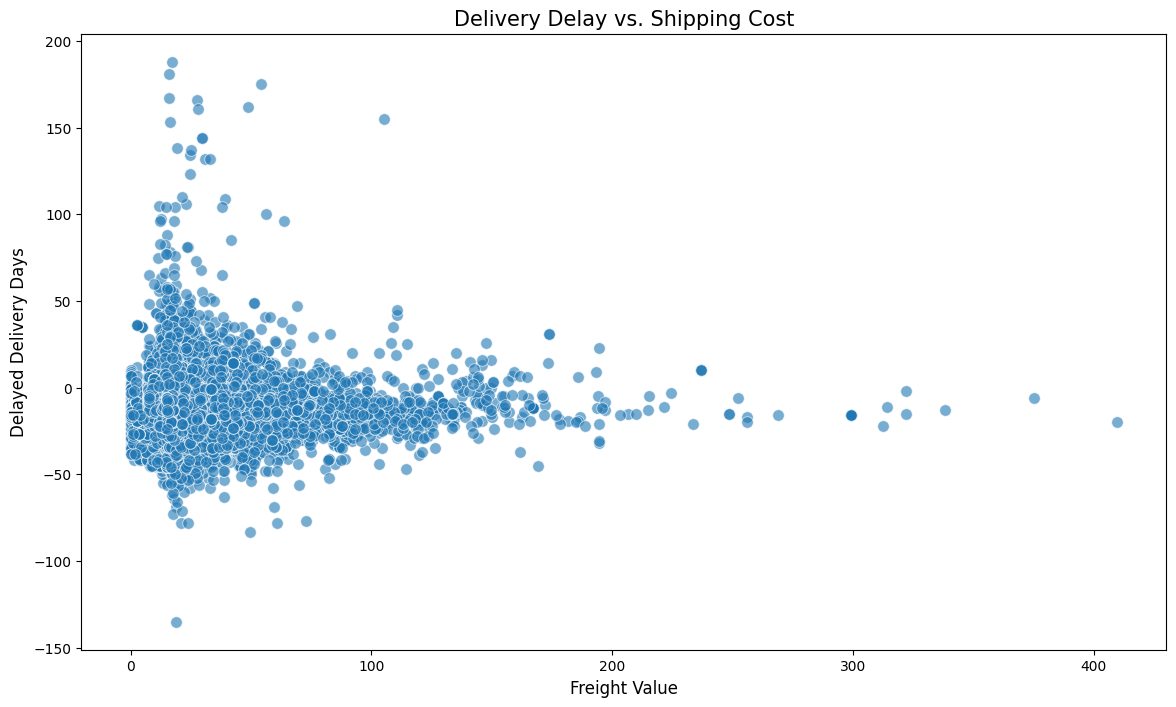

In [ ]:
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(x='freight_value', y='delayed_delivery_days',
    data=order_df, alpha=0.6, edgecolor='w',s=70)

plt.title('Delivery Delay vs. Shipping Cost', fontsize=15)
plt.xlabel('Freight Value', fontsize=12)
plt.ylabel('Delayed Delivery Days', fontsize=12)

plt.show()

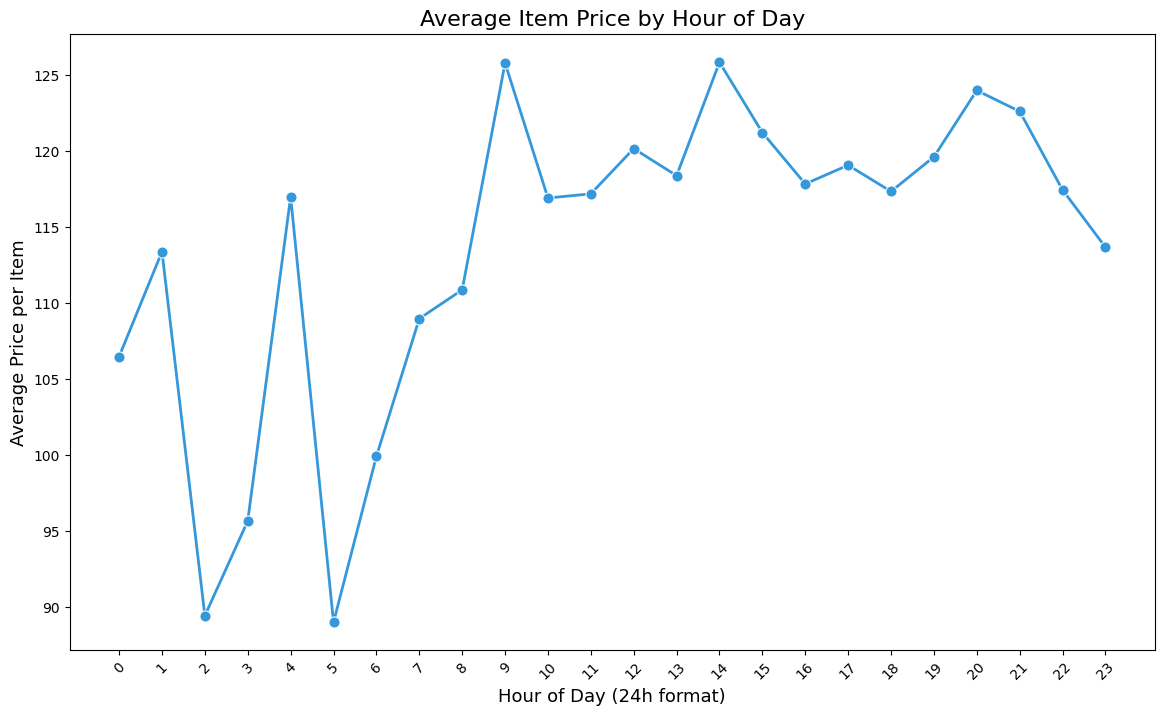

In [ ]:
plt.figure(figsize=(14, 8))
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])

order_df['hour'] = order_df['order_purchase_timestamp'].dt.hour
order_df['day_of_week'] = order_df['order_purchase_timestamp'].dt.dayofweek  
order_df['day_name'] = order_df['order_purchase_timestamp'].dt.day_name()
order_df['month'] = order_df['order_purchase_timestamp'].dt.month
order_df['date'] = order_df['order_purchase_timestamp'].dt.date

hourly_avg = order_df.groupby('hour')['avg_price_per_item'].mean().reset_index()

sns.lineplot(x='hour', y='avg_price_per_item', data=hourly_avg, marker='o',
    markersize=8, color='#3498db', linewidth=2)

plt.title('Average Item Price by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (24h format)', fontsize=13)
plt.ylabel('Average Price per Item', fontsize=13)
plt.xticks(np.arange(0, 24), rotation=45)

plt.show()


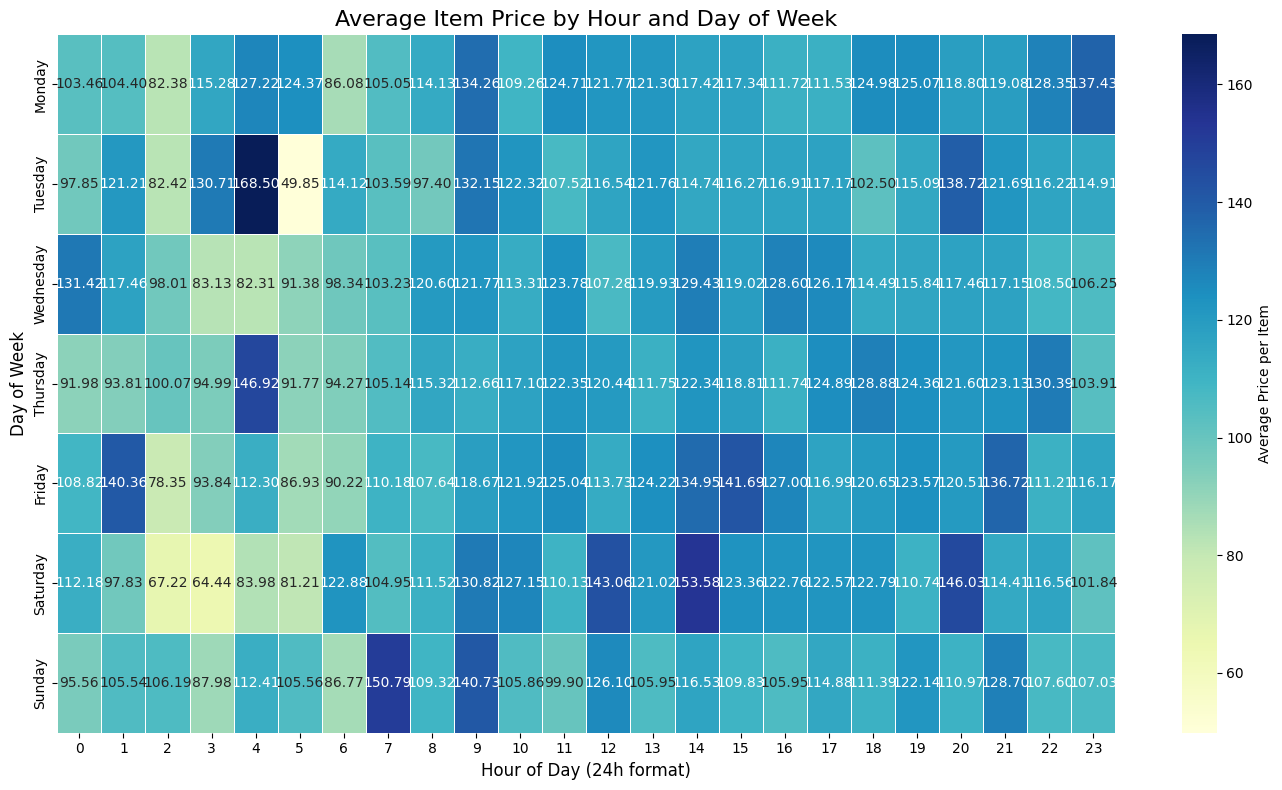

In [ ]:
plt.figure(figsize=(14, 8))


heatmap_data = order_df.groupby(['day_of_week', 'hour'])['avg_price_per_item'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='day_of_week', columns='hour', values='avg_price_per_item')

ax = sns.heatmap(
    heatmap_pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cbar_kws={'label': 'Average Price per Item'}
)

ax.set_ylabel('Day of Week', fontsize=12)
ax.set_xlabel('Hour of Day (24h format)', fontsize=12)
ax.set_title('Average Item Price by Hour and Day of Week', fontsize=16)

ax.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.tight_layout()
plt.show()


# Feature Engineering & Model Training


## 1. Total price per order

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
# Converting timestamp to datetime and extract features
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])
order_df['purchase_day'] = order_df['order_purchase_timestamp'].dt.day
order_df['purchase_month'] = order_df['order_purchase_timestamp'].dt.month
order_df['purchase_year'] = order_df['order_purchase_timestamp'].dt.year
order_df['purchase_day_of_week'] = order_df['order_purchase_timestamp'].dt.dayofweek
order_df['is_weekend'] = order_df['purchase_day_of_week'].isin([5, 6]).astype(int)
#order_df['purchase_hour'] = order_df['order_purchase_timestamp'].dt.hour


In [ ]:
# Preparing input and output features for model training 
y = order_df['final_price_per_order']

features = [
    'num_items_per_order',
    'avg_price_per_item',
    'freight_value',
    'purchase_day',
    'purchase_month',
    'purchase_year',
    'is_weekend'
    #'purchase_hour',
    #'purchase_day_of_week',
    #'order_status',
    #'freight_ratio',
    #'unique_products_per_order',
]

X = order_df[features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Using XGBoost and its evaluation

In [ ]:
# First model - xgbregressor
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
) 

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [ ]:
# Evaluation of the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(results_df.head(10))

Mean Squared Error: 2475.73
R² Score: 0.96
       Actual   Predicted
68262    40.0   39.066566
52908   269.9  266.813568
61760   168.0  168.593552
60502    65.9   64.937798
58528   189.9  189.932648
16701   320.0  313.472321
70624   115.0  115.684258
49085    40.7   41.737003
15681    40.0   39.066566
26180   120.0  121.015305


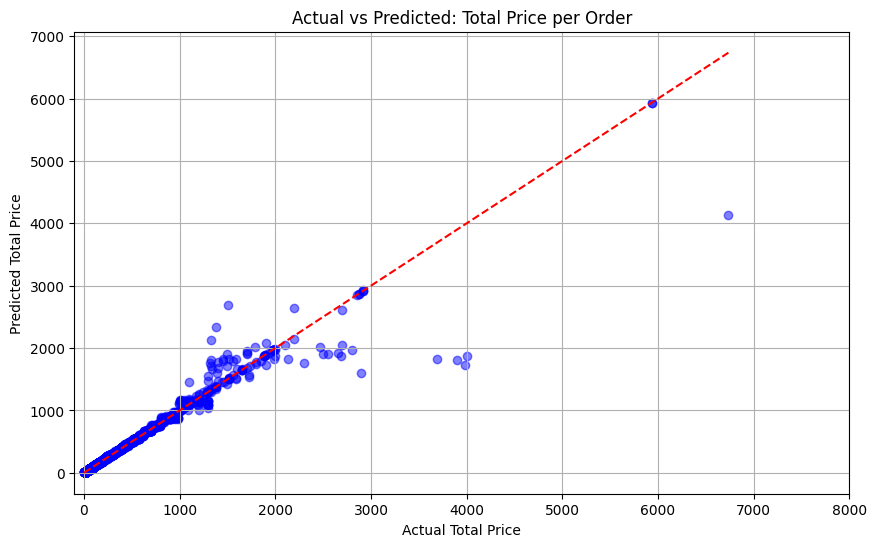

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Total Price')
plt.xlim(-100, 8000)
plt.ylabel('Predicted Total Price')
plt.title('Actual vs Predicted: Total Price per Order')

plt.grid()
plt.show()


### Using Random Forest and its evaluation

In [74]:
# Second model - Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1  
)

rf_model.fit(X_train, y_train)
y_pred2 = rf_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)

print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MSE: 74.68
R² Score: 1.00


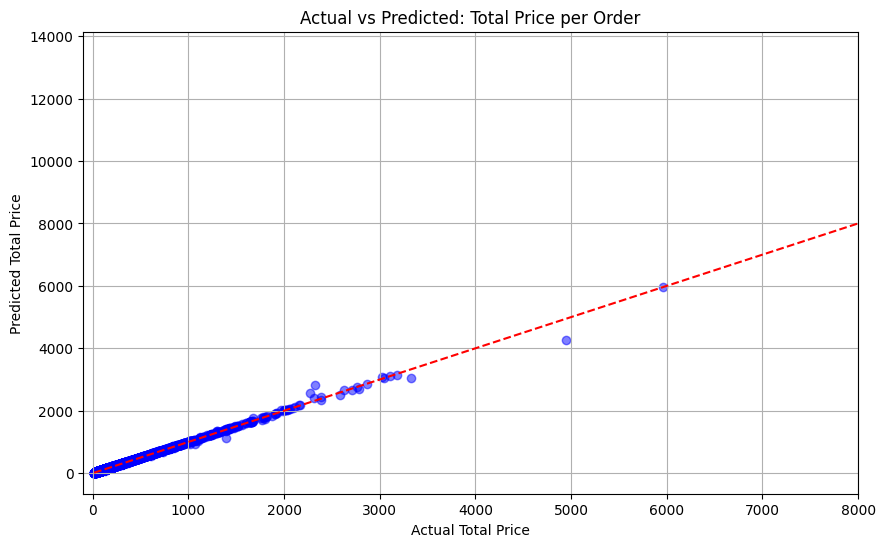

In [75]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred2, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Total Price')
plt.xlim(-100, 8000)
plt.ylabel('Predicted Total Price')
plt.title('Actual vs Predicted: Total Price per Order')

plt.grid()
plt.show()


In [76]:
# Checking the model prediction
new_data = pd.DataFrame([{
    'num_items_per_order': 1,
    'avg_price_per_item': 57,
    'freight_value': 8.77,
    'purchase_day': 4,
    'purchase_month': 10,
    'purchase_year': 2016,
    'is_weekend': 0
}])

prediction = rf_model.predict(new_data)
print("Predicted value:", prediction[0])


Predicted value: 65.94180015214282


# 2. Total Revenue per Day

In [78]:
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])
order_df['purchase_date'] = order_df['order_purchase_timestamp'].dt.date

# Aggregating features to get per day numbers
order_df_agg = order_df.groupby('purchase_date')[
    ['total_price_per_order', 'num_items_per_order', 'avg_price_per_item', 'freight_value', 'final_price_per_order']
].sum().reset_index()

order_df_agg['purchase_date'] = pd.to_datetime(order_df_agg['purchase_date'])
order_df_agg['purchase_day'] = order_df_agg['purchase_date'].dt.day
order_df_agg['purchase_month'] = order_df_agg['purchase_date'].dt.month
order_df_agg['purchase_year'] = order_df_agg['purchase_date'].dt.year

order_df_agg

,purchase_date,total_price_per_order,num_items_per_order,avg_price_per_item,freight_value,final_price_per_order,purchase_day,purchase_month,purchase_year
0,2016-09-15,405.0,9,135.0,8.490000,413.490000,15,9,2016
1,2016-10-03,390.2,5,390.2,84.800001,475.000001,3,10,2016
2,2016-10-04,7386.0,66,5710.2,874.409999,8260.409999,4,10,2016
3,2016-10-05,5410.9,61,3224.6,647.619999,6058.519999,5,10,2016
4,2016-10-06,5667.2,40,4647.8,600.880001,6268.080001,6,10,2016
...,...,...,...,...,...,...,...,...,...
607,2018-08-25,7342.8,65,6459.0,816.090001,8158.890001,25,8,2018
608,2018-08-26,4129.8,54,3680.2,620.349998,4750.149998,26,8,2018
609,2018-08-27,3477.6,53,3095.7,500.960000,3978.560000,27,8,2018
610,2018-08-28,3577.9,48,3014.9,326.220001,3904.120001,28,8,2018


In [ ]:
# Preparing input and output features for model training  
y = order_df_agg['final_price_per_order']

features2 = [
    'num_items_per_order',
    'avg_price_per_item',
    'freight_value',
    'purchase_day',
    'purchase_month',
    'purchase_year'
]

X = order_df_agg[features2]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [80]:
# Random Forest Model 
rf_model2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1  
)

rf_model2.fit(X_train, y_train)
y_pred2 = rf_model2.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)

print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MSE: 4151638.07
R² Score: 0.96


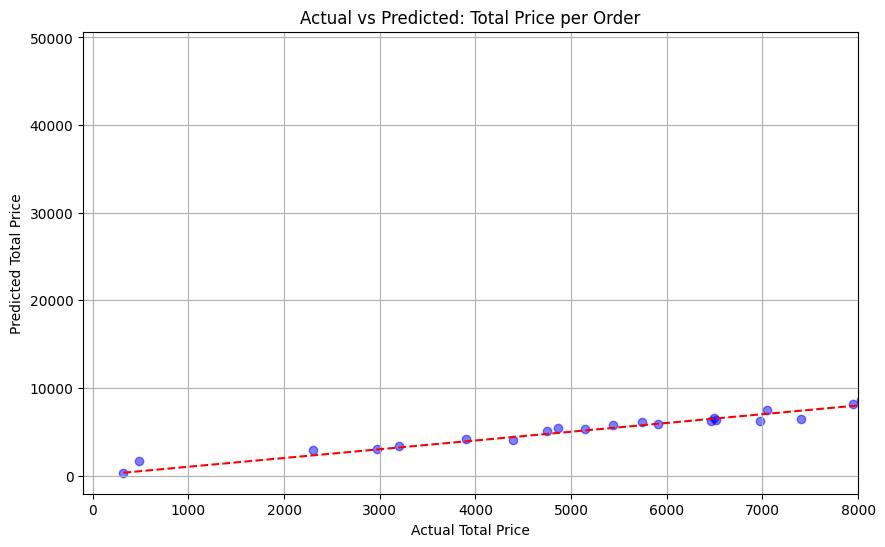

In [81]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred2, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Total Price')
plt.xlim(-100, 8000)
plt.ylabel('Predicted Total Price')
plt.title('Actual vs Predicted: Total Price per Order')

plt.grid()
plt.show()

In [82]:
# Checking model prediciton 
new_data = pd.DataFrame([{
    'num_items_per_order': 9,
    'avg_price_per_item': 135,
    'freight_value': 8.49,
    'purchase_day': 15,
    'purchase_month': 9,
    'purchase_year': 2016
}])

prediction = rf_model2.predict(new_data)
print("Predicted value:", prediction[0])


Predicted value: 428.76779998779307


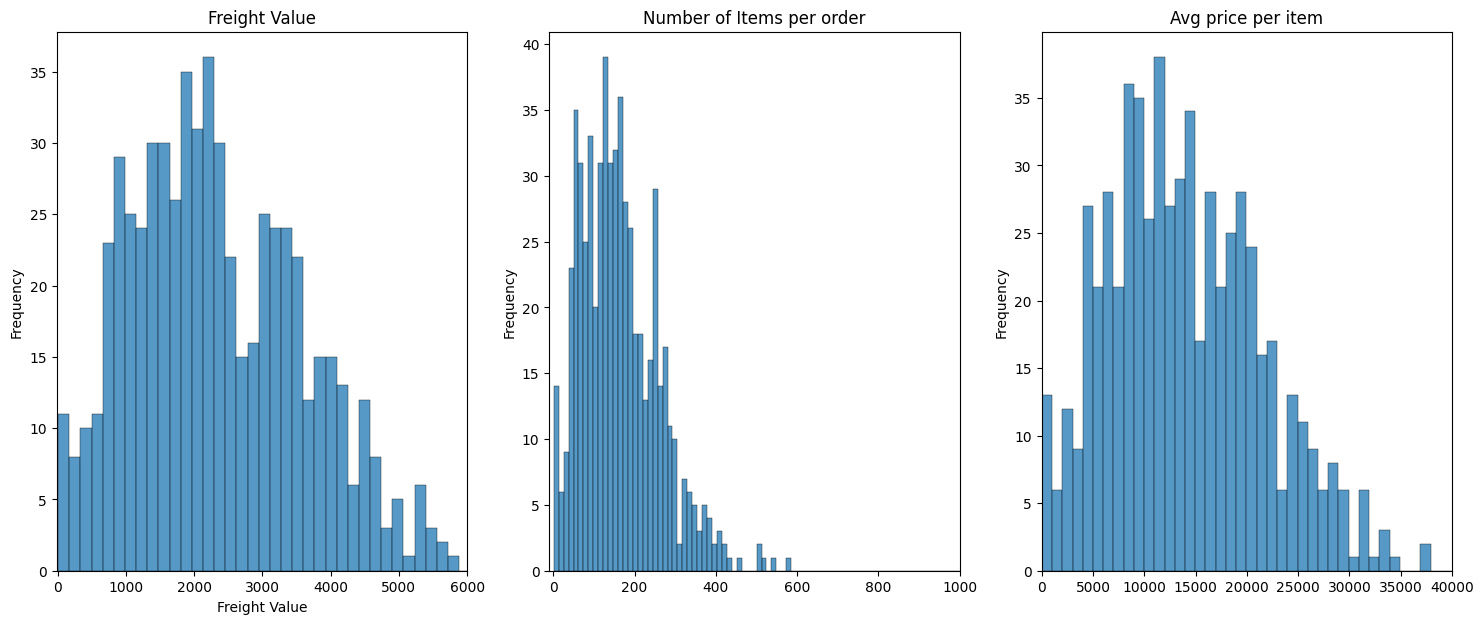

In [83]:
# Aggregated stats for Freight Value, Avg. Price per Item and No. of Items per order to be used as default values in the app
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

sns.histplot(data=order_df_agg, x='freight_value', bins=100, ax=axes[0])
axes[0].set_title('Freight Value')
axes[0].set_xlabel('Freight Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim([-10, 6000])

sns.histplot(data=order_df_agg, x='num_items_per_order', bins=100, ax=axes[1])
axes[1].set_title('Number of Items per order')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim([-10, 1000])

sns.histplot(data=order_df_agg, x='avg_price_per_item', bins=100, ax=axes[2])
axes[2].set_title('Avg price per item')
axes[2].set_xlabel('')
axes[2].set_ylabel('Frequency')
axes[2].set_xlim([-10, 40000])

plt.show()

In [95]:
print(order_df_agg['avg_price_per_item'].mean())
print(order_df_agg['avg_price_per_item'].std())

14119.43431372549
8170.003049073166


## 2. Delayed delivery indicator

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

In [88]:
# Preparing features for the classification 
order_df['delayed_delivery_indicator'] = \
    (order_df['delayed_delivery_days'] > 0).astype(int)

y = order_df['delayed_delivery_indicator']

feature3 = [
    'num_items_per_order',
    'avg_price_per_item',
    'freight_value',
    'purchase_day',
    'purchase_month',
    'purchase_year',
    'is_weekend'
]

X = order_df[feature3]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [89]:
# Model - Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13608
           1       0.62      0.21      0.31       956

    accuracy                           0.94     14564
   macro avg       0.78      0.60      0.64     14564
weighted avg       0.92      0.94      0.93     14564



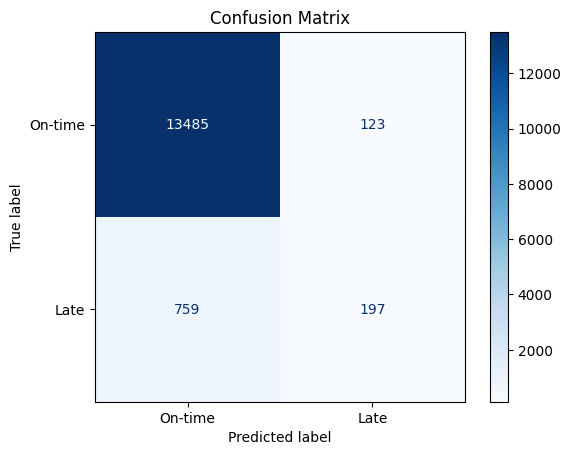

In [90]:
# Model evaluation
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On-time", "Late"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

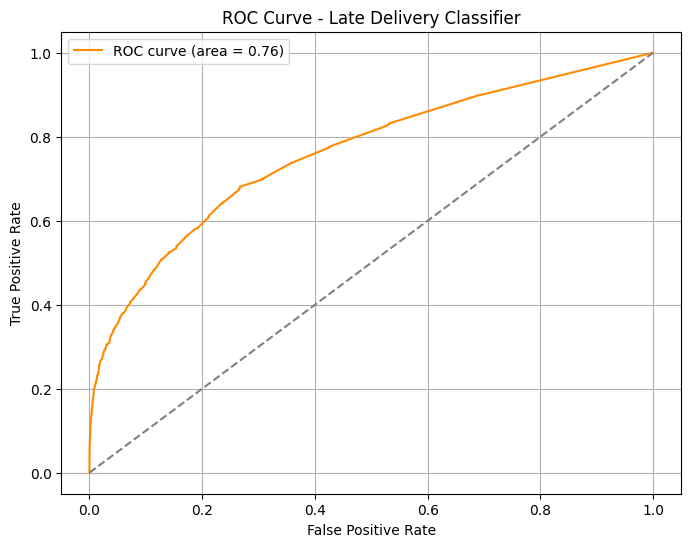

In [ ]:
y_probs = classifier.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Late Delivery Classifier')

plt.legend()
plt.grid()
plt.show()

# Model and Data Saving

In [94]:
import joblib 

joblib.dump(rf_model, "rf_reg_compressed.pkl", compress=3)
joblib.dump(rf_model2, "rf_reg2_compressed.pkl", compress=3)
joblib.dump(classifier, "rf_cl_compressed.pkl", compress=3)

['rf_cl_compressed.pkl']

In [92]:
order_df.to_csv("order_df.csv", index=False)
order_df_agg.to_csv("order_df_agg.csv", index=False)
